In [1]:
%reset -f
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import pylab as pl
from generate_data import generate_data
from statsmodels.discrete.discrete_model import Logit as logreg
from sklearn.metrics import roc_auc_score

from matplotlib import rc
rc('text', usetex=True)

## Illustration du sur-apprentissage et de l'importance du Goodness-of-fit

Imaginons qu'on a des donnée en dimension 12 dont voici les 5 premières lignes, avec le label Y en dernière colonne. On est dans un cas de prédiction binaire, on va utiliser une regression logistique.

In [146]:
n_samples = 50
seed = 43210
X, Y, mean1, mean2 = generate_data(n_samples,seed)
df = pd.DataFrame(X)
df["Y"] = Y
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Y
0,2.319266,1.362535,7.329070,4.305723,12.475318,2.529550,31.556945,23.160460,13.606437,9.986117,53.715263,18.539252,73.188946,42.997453,99.722526,0
1,2.180374,3.246000,15.431580,22.973538,10.365564,34.201516,354.517998,109.216898,162.595047,50.090903,238.133675,527.783444,772.981796,1150.765254,2509.098543,0
2,2.450655,1.057724,6.352383,2.741742,14.717930,1.183359,17.416593,16.466112,7.106912,6.719064,40.352765,7.517148,42.682068,18.421940,45.145827,0
3,2.326152,0.813101,4.399676,1.537897,12.586767,0.537568,6.766247,8.321532,2.908773,3.577381,19.357146,2.365126,15.739317,5.501643,12.797656,0
4,2.306424,2.209820,11.755339,11.262972,12.269230,10.791228,132.400057,59.914401,57.404914,25.977187,138.187998,126.854542,305.370638,292.580330,674.814226,0


In [147]:
# On lance l'entraînement du modèle
model = logreg(Y, X)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.116093
         Iterations 16


In [148]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       85
Method:                           MLE   Df Model:                           14
Date:                Sun, 05 Aug 2018   Pseudo R-squ.:                  0.8325
Time:                        18:15:16   Log-Likelihood:                -11.609
converged:                       True   LL-Null:                       -69.315
                                        LLR p-value:                 4.961e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -65.3428     35.360     -1.848      0.065    -134.647       3.961
x2             9.7074      7.445      1.304      0.192      -4.885      24.300
x3           -57.6128     31.796     -1.812      0.070    -119.931       4.706
x4            10.9412      6.531      1.675      0.094      -1.859      23.741
x5            15.4106      8.450      1.824      0.068      -1.151      31.972
x6            -2.3770      1.559     -1.525      0.127      -5.432       0.678
x7            12.9699      7.100      1.827      0.068      -0.945      26.885
x8           -24.6662     13.558     -1.819      0.069     -51.239       1.906
x9           -38.5669     20.955     -1.840      0.066     -79.637       2.503
x10           91.2571     49.606      1.840      0.066      -5.969     188.483
x11            1.9271      1.097      1.757      0.079      -0.223       4.077
x12            4.7489      2.579      1.841      0.066      -0.306       9.803
x13           -1.1475      0.640     -1.792      0.073      -2.402       0.108
x14           -1.7698      0.965     -1.834      0.067      -3.661       0.122
x15            0.1692      0.093      1.814      0.070      -0.014       0.352
==============================================================================

Possibly complete quasi-separation: A fraction 0.47 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Après la phase d'apprentissage, regardons ce que donnent les p_values associées à chaques coeffs

In [149]:
alpha = .1
idx = np.where(result.pvalues < alpha)[0]
print("En prenant un seuil à %.0f%% sur les p_values, on déduit donc que " % (alpha * 100), end="")
for i,index in enumerate(idx):
    if i > 0:
        print(", ", end="")
    print("x_%s" % (index + 1), end="")
print(" sont significatifs!")

En prenant un seuil à 10% sur les p_values, on déduit donc que x_1, x_3, x_4, x_5, x_7, x_8, x_9, x_10, x_11, x_12, x_13, x_14, x_15 sont significatifs!


## Sauf qu'à aucun moment on a regardé ici le goodness-of-fit du modèle!!

Voyons voir les prédictions en terme d'AUC sur de nouvelles données générées par le même processus que les données utilisées pour l'apprentissage, de façon à quantifier le goodness-of-fit. On regarde aussi l'AUC sur la prédiction obtenue sur les données d'apprentissage.

In [150]:
# prédiction sur les données d'apprentissage
Y_pred = result.predict(X)

# AUC obtenu
auc_training = roc_auc_score(Y, Y_pred)

# on génére de nouvelles données de test
X_test, Y_test,_,_ = generate_data(1000,seed)

# on prédit la sortie avec notre modèle entrainé
Y_test_pred = result.predict(X_test)

# on regarde le score en terme d'AUC
auc_test = roc_auc_score(Y_test, Y_test_pred)
print("AUC sur training set: %.2f\nAUC sur jeu de test: %.2f" % (auc_training, auc_test))

AUC sur training set: 0.99
AUC sur jeu de test: 0.88


Il y a donc une dégradation de la performance en prédiction si on prédit sur des données que le modèle n'a pas vu pendant la phase d'apprentissage! On soupsonne un sur-apprentissage qui remettrait en cause nos conclusions précédentes sur l'association significative des variables.

En fait les données ont été générées par un mélange de gaussiennes multivariées en 2d, et les autres features sont des produits de puissances des deux premières features. De cette façon, la fonction de prédiction est non linéaire et dispose d'une complexité qui lui permet de se "tordre facilement" et donc de sur-apprendre les données.

Si on plot les 2 premières features en 2d on voit bien les 2 classes et le mélange de gaussiennes.

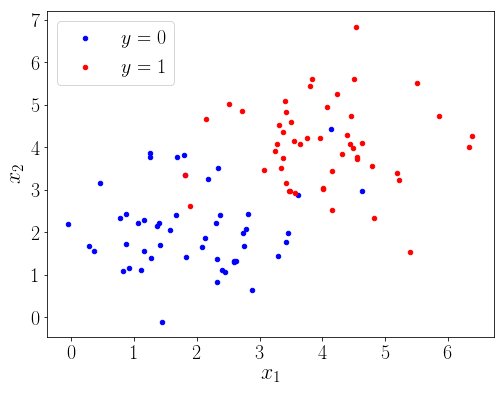

In [151]:
# scatter plot, dots colored by class value
colors = {0:'b', 1:'r'}
fig, ax = pl.subplots(figsize=(8, 6))
grouped = df.groupby('Y')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x=0, y=1, 
               label="$y = %s$" % key, color=colors[key])
pl.legend(fontsize=20)
pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)
pl.xlabel(r"$x_1$", fontsize=22)
pl.ylabel(r"$x_2$", fontsize=22)
pl.savefig('./simulated_data.pdf', bbox_inches='tight')
pl.show()

Si on ajoute maintenant à ce graphe la fonction de décision (gradient de couleur pour la probabilité prédite d'être dans la classe rouge ou bleu), alors on se rend compte que le modèle a sur-appris les données d'apprentissage. Comme on pouvait le soupçonner étant donné le comportement en prédiction sur de nouvelles données.

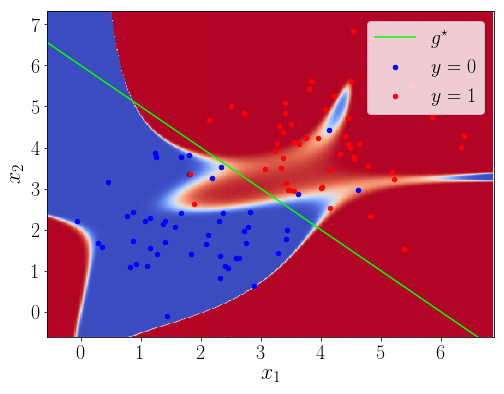

In [152]:
h = .02 
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx_1, xx_2 = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = result.predict(np.c_[xx_1.ravel(), 
                         xx_2.ravel(),
                         (xx_1 ** 2 * xx_2).ravel(), 
                         (xx_2 ** 2 * xx_1).ravel(),
                         (xx_1 ** 3).ravel(),
                         (xx_2 ** 3).ravel(),
                         (xx_1 ** 3 * xx_2 ** 3).ravel(),
                         (xx_1 ** 3 * xx_2 ** 2).ravel(),
                         (xx_2 ** 3 * xx_1 ** 2).ravel(),
                         (xx_1 ** 2 * xx_2 ** 2).ravel(),
                         (xx_1 ** 4 * xx_2 ** 2).ravel(),
                         (xx_2 ** 4 * xx_1 ** 2).ravel(),
                         (xx_1 ** 4 * xx_2 ** 3).ravel(),
                         (xx_2 ** 4 * xx_1 ** 3).ravel(),
                         (xx_1 ** 4 * xx_2 ** 4).ravel()
                        ])

Z = Z.reshape(xx_1.shape)

fig, ax = pl.subplots(figsize=(8, 6))
x_grid = np.linspace(x_min, x_max, 200)

a = -(mean1[0] - mean2[0]) / (mean1[1] - mean2[1])
b = (mean1[1] + mean2[1])/2 - a * (mean1[0] + mean2[0])/2
pl.plot(x_grid, a * x_grid + b, color="lime", label="$g^\star$")

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

pl.pcolormesh(xx_1, xx_2, Z, cmap=pl.cm.coolwarm, alpha=0.9)
grouped = df.groupby('Y')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x=0, y=1, 
               label="$y = %s$" % key, color=colors[key])

pl.legend(fontsize=20)
pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)
pl.xlabel(r"$x_1$", fontsize=22)
pl.ylabel(r"$x_2$", fontsize=22)
pl.savefig('./decision_function.jpg', bbox_inches='tight')
pl.show()

## Illustration de la régularisation $||x||_p$

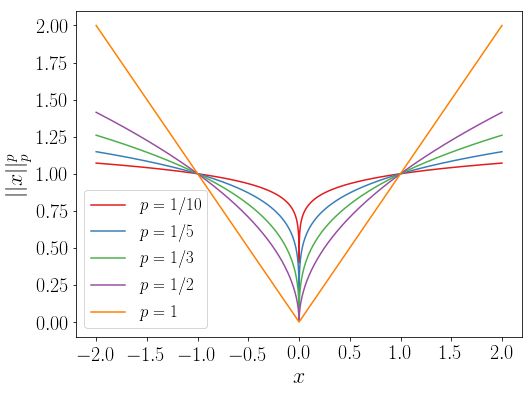

In [204]:
import seaborn.apionly as sns
palette = sns.color_palette("Set1")

x = np.concatenate((np.linspace(-2, -.1, 500), 
                    np.linspace(-.1, .1, 1000),
                    np.linspace(.1, 2, 500)))
p_grid = [1/10, 1/5, 1/3, 1/2, 1]
p_grid_string = ["1/10", "1/5", "1/3", "1/2", "1"]

fig, ax = pl.subplots(figsize=(8, 6))
for i,p in enumerate(p_grid):
    pl.plot(x, (np.abs(x) ** p) , 
            label="$p=%s$" % p_grid_string[i],
            color = palette[i])
pl.legend(fontsize=17)
pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)
pl.xlabel(r"$x$", fontsize=22)
pl.ylabel(r"$||x||_p^p$", fontsize=22)
pl.savefig('./lp_norm.pdf', bbox_inches='tight')
pl.show()